## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [154]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sc
import scipy.sparse.linalg
from utils import *
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
import scipy.sparse.linalg as spla


# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /content/drive/My Drive/cs445_projects/proj3/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj3/samples: No such file or directory


## Part 1 Toy Problem (20 pts)

In [188]:
def toy_reconstruct(toy_img):
    im_h, im_w, _ = toy_img.shape
    im_out = np.zeros((im_h, im_w, 3), dtype=np.double)

    M = im_h * (im_w - 1) + (im_h - 1) * im_w + 1
    N = im_h * im_w

    im2var = np.arange(N).reshape(im_h, im_w)

    A = sp.lil_matrix((M, N))
    b = np.zeros((M, 3))

    e = -1

    for i in range(im_h):
        for j in range(im_w):
            if j != im_w - 1:
                e += 1
                A[e, im2var[i, j + 1]] = 1
                A[e, im2var[i, j]] = -1
                b[e] = toy_img[i, j + 1] - toy_img[i, j]

            if i != im_h - 1:
                e += 1
                A[e, im2var[i + 1, j]] = 1
                A[e, im2var[i, j]] = -1
                b[e] = toy_img[i + 1, j] - toy_img[i, j]

    e += 1
    A[e, im2var[im_h - 1, im_w - 1]] = -1
    b[e] = -toy_img[im_h - 1, im_w - 1]

    A = sp.csr_matrix(A)
    v = np.zeros((N, 3))

    for channel in range(3):
        v[:, channel] = spla.lsqr(A, b[:, channel], atol=1e-8, btol=1e-7)[0]

    for i in range(im_h):
        for j in range(im_w):
            im_out[i, j, :] = v[im2var[i, j], :]

    return im_out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error value is: 0.0004993809745444583


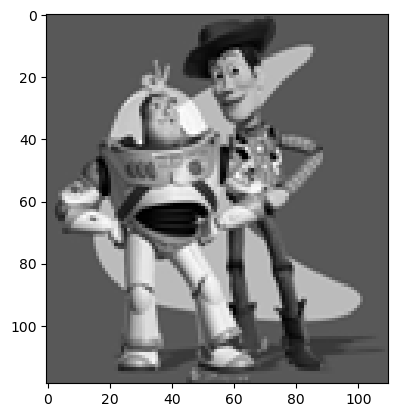

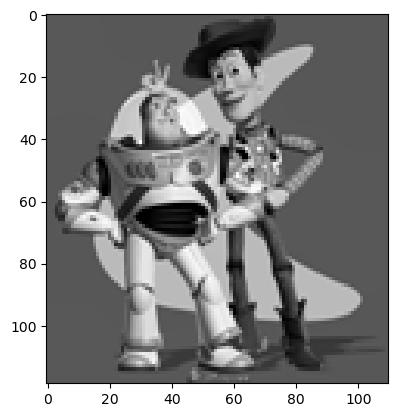

In [189]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
im_out = toy_reconstruct(toy_img)

error = np.sqrt(((im_out - toy_img) ** 2).sum())
print("Error value is:", error) #prof said <0.01?

# Display
plt.figure()
plt.imshow(toy_img)
plt.figure()
plt.imshow(im_out)
plt.show()

## Preparation

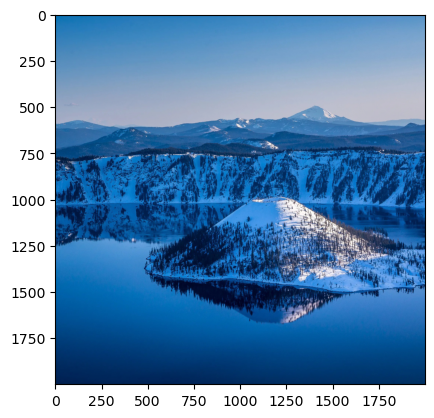

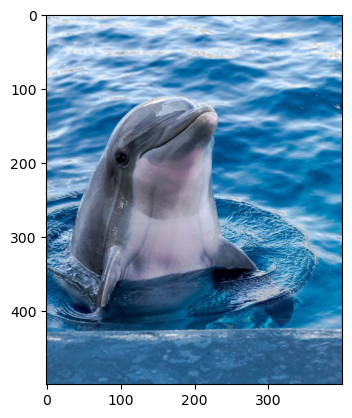

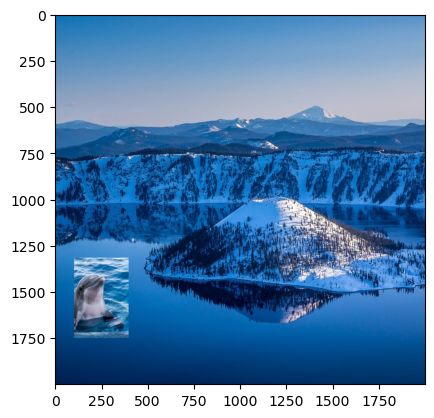

In [177]:
background_img = cv2.cvtColor(cv2.imread('samples/water.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/dolphin.jpEg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = get_mask(ys, xs, object_img)
  bottom_center = (250,1750) # (x,y)

  object_img, object_mask = crop_object_img(object_img, object_mask)
  bg_ul = upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(get_combined_img(background_img, object_img, object_mask, bg_ul))

In [178]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [179]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [180]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [181]:
import numpy as np
import scipy.sparse as sp

def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels.
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param bg_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    def helper(i, j):
        return [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]

    im_s = object_img
    im_t = bg_img
    im_mask = object_mask

    ii, jj = np.nonzero(object_mask)
    im_h, im_w = im_s.shape
    im_out = bg_img.copy()
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T

    M = 4 * len(ii) + 1
    N = im_h * im_w

    A = sp.lil_matrix((M, N))
    b = np.zeros(M)
    e = 0

    for n in range(len(ii)):
        i, j = ii[n], jj[n]
        for i1, j1 in helper(i, j):
            e += 1
            A[e, im2var[i, j]] = 1

            if im_mask[i1, j1]:
                A[e, im2var[i1, j1]] = -1
                b[e] = im_s[i, j] - im_s[i1, j1]
            else:
                b[e] = im_s[i, j] - im_s[i1, j1] + bg_img[bg_ul[0] + i1, bg_ul[1] + j1]

    A = sp.csr_matrix(A)
    v = sp.linalg.lsqr(A, b)

    for n in range(len(ii)):
        i, j = ii[n], jj[n]
        im_out[i + bg_ul[0], j + bg_ul[1]] = v[0][im2var[i, j]]

    return im_out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


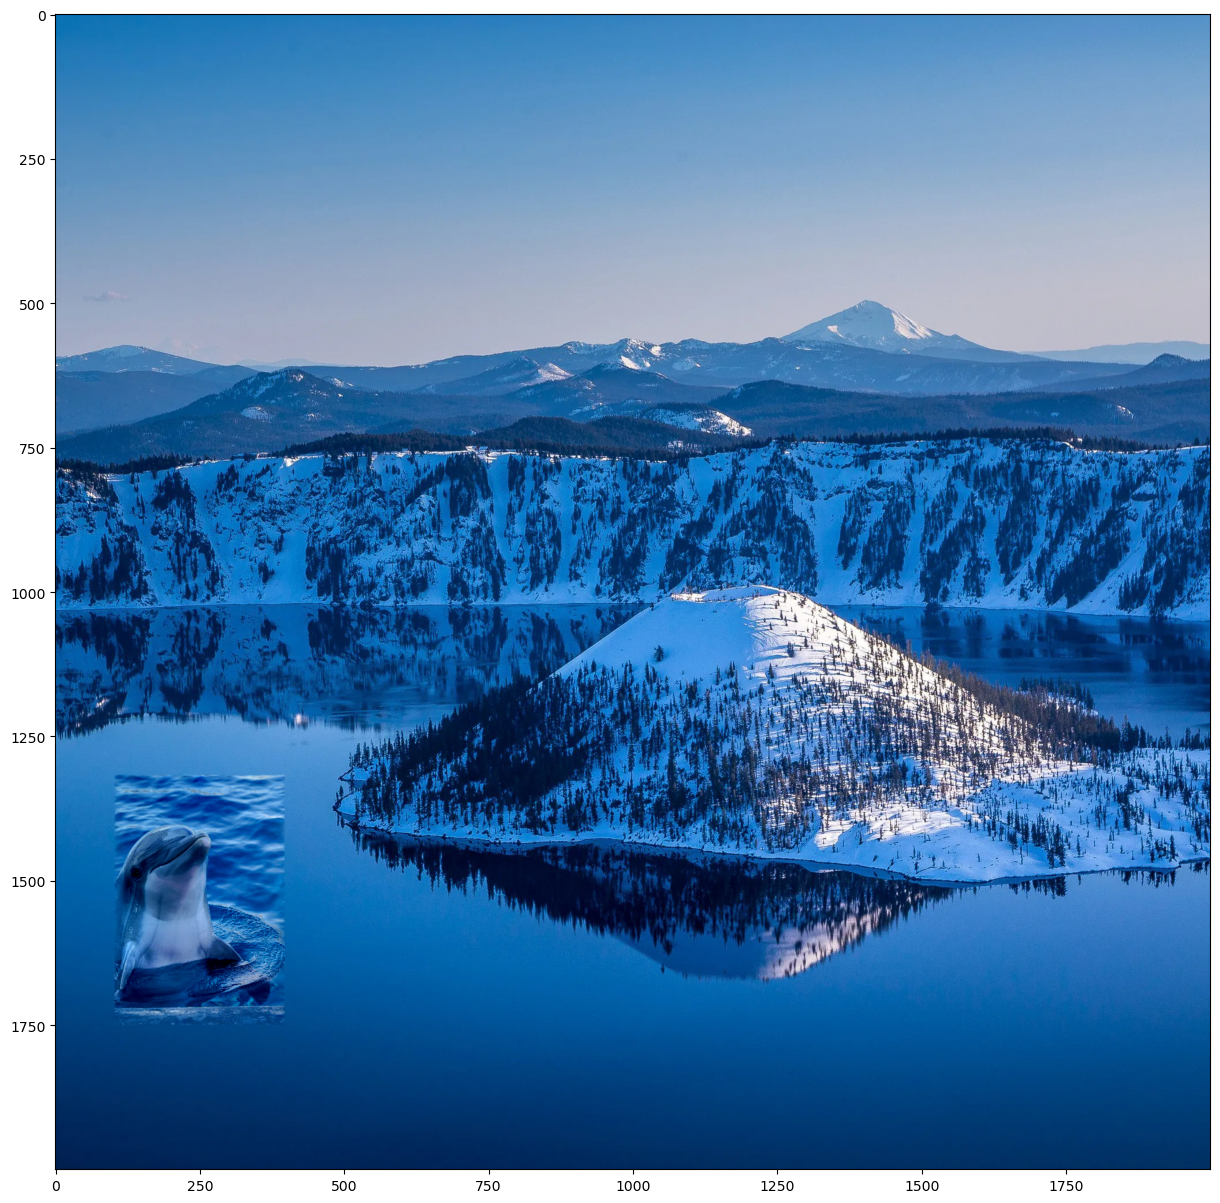

In [182]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [169]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at the position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object (single channel)
    :param object_mask: the mask of the foreground object in object_img
    :param bg_img: the background image (single channel)
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    def helper(i, j):
        return [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]

    im_h, im_w = object_img.shape
    im_out = bg_img.copy()
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T

    [ii, jj] = np.nonzero(object_mask)

    M = 4 * len(ii) + 1
    N = im_h * im_w
    A = sc.sparse.lil_matrix((M, N))
    b = np.zeros(M)
    e = 0

    for n in range(len(ii)):
        i, j = ii[n], jj[n]

        for (i1, j1) in helper(i, j):
            e += 1
            A[e, im2var[i, j]] = 1
            sgradient = object_img[i, j] - object_img[i1, j1]
            tgradient = bg_img[i, j] - bg_img[i1, j1]

            if object_mask[i1, j1]:
                A[e, im2var[i1, j1]] = -1

                if abs(sgradient) > abs(tgradient):
                    gradient = sgradient
                else:
                    gradient = tgradient
                b[e] = gradient
            else:
                if abs(sgradient) > abs(tgradient):
                    gradient = sgradient + bg_img[bg_ul[0] + i1, bg_ul[1] + j1]
                else:
                    gradient = tgradient + bg_img[bg_ul[0] + i1, bg_ul[1] + j1]
                b[e] = gradient

    A = sc.sparse.csr_matrix(A)
    v = sc.sparse.linalg.lsqr(A, b)
    
    for n in range(len(ii)):
        i, j = ii[n], jj[n]
        im_out[i + bg_ul[0], j + bg_ul[1]] = v[0][im2var[i, j]]
    
    return im_out


In [170]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

IndexError: index 377 is out of bounds for axis 0 with size 377

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [91]:
def color2gray(img):

    gray_img = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

    gradient_gray = np.gradient(gray_img)

    gradient_magnitude = np.sqrt(gradient_gray[0] ** 2 + gradient_gray[1] ** 2)

    gray_img = gray_img + (gray_img.mean() / gradient_magnitude.mean()) * gradient_magnitude

    gray_img = (gray_img - gray_img.min()) / (gray_img.max() - gray_img.min()) * 255

    gray_img = gray_img.astype(np.uint8)

    return gray_img

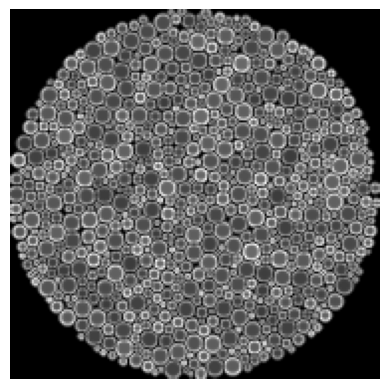

In [92]:

img = cv2.imread('samples/colorBlind4.png')

gray_img = color2gray(img)

plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)